<a href="https://colab.research.google.com/github/DataMastersUN/FA_T3/blob/main/Trabajo_3_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **Fundamentos de Analítica**

##**Trabajo 3: Clasificación de Imágenes**

Integrantes:

Anderson Elian Gutierrez Bueno
angutierrezb@unal.edu.co

David Antonio Castro Tamayo
dcastrot@unal.edu.co

Luis Javier Asprilla Galarcio
lasprilla@unal.edu.co


</center>

Se tiene un conjunto de imágenes de personas con y sin gafas, en las que los individuos aparecen con diferentes expresiones faciales y ángulos, descargado de la fuente:https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images

Objetivo: Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas con el conjunto de datos dado.

In [45]:
# Librerias usadas
import os
import re
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from skimage import io
from random import shuffle
from tensorflow import keras
from collections import Counter
from keras.models import Sequential
from sklearn.decomposition import PCA
from random import randint, choice, choices
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, Activation, BatchNormalization
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# **Carga de datos**

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


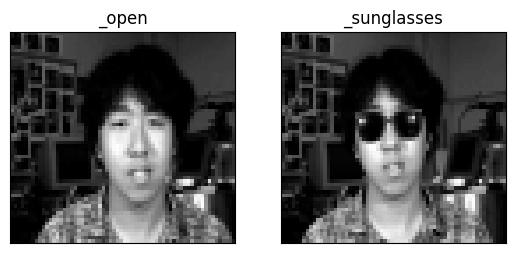

In [91]:
imagen_1 = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces/an2i/an2i_straight_sad_open_2.pgm')
imagen_2 = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces/an2i/an2i_straight_sad_sunglasses_2.pgm')
plt.subplot(1, 2, 1)
plt.imshow(imagen_1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('_open')

plt.subplot(1, 2, 2)
plt.imshow(imagen_2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('_sunglasses')

plt.show()

In [92]:
imagen_1.close()
imagen_2.close()

Los datos, tanto las imágenes como las etiquetas, se guardaron en dos únicos archivos binarios para evitar la carga reiterada de todas las imágenes desde el destino. Y se procede a cargar y trabajar con dichos ficheros.

In [55]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'

with open(ruta_archivo, 'rb') as archivo:
    images = pickle.load(archivo)
print(f'Se encontraron {len(images)} imágenes PGM.')

Se encontraron 624 imágenes PGM.


In [56]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'

with open(ruta_archivo, 'rb') as archivo:
    etiquetas = pickle.load(archivo)
print(f'Se encontraron {len(etiquetas)} etiquetas')

Se encontraron 624 etiquetas


In [57]:
#guardado unicamente de las etiquetas 'open' y 'sunglasses'
labels = [ruta.split('_')[-2].split('.')[0] for ruta in etiquetas]

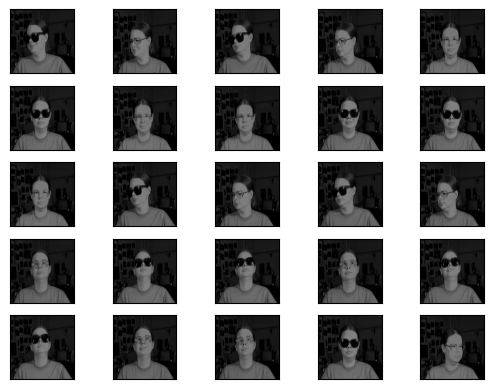

In [58]:
#Muestra de las imágenes cargadas
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [59]:
images[7].shape

(64, 64, 3)

Estos números representan en la imagen actual, el alto, ancho y canales de color, respectivamente. El canal de color con el valor de 3 hace referencia a que cada pixel tiene tres valores: rojo, verde y azul.

# **Preprocesamiento de datos**

## Transformación a escala de grises, y normalización de imágenes

In [60]:
#Transformación explícita a grises
images_gray = []
for i in range(len(images)):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(image)

images_gray[4].shape

(64, 64)

Ahora sólo aparecen dos valores, alto y ancho, indicando que, actualmente, las imágenes se encuentran guardadas en escala de grises con una sola dimensión de canal. En cada píxel de la imagen en blanco y negro, los valores suelen estar en el rango de 0 a 255, donde 0 representa negro y 255 representa blanco, los valores intermedios representan tonos de gris.

Se procede con la **normalización de pixeles**, dividiendo cada valor de píxel por el valor máximo posible (255 en el caso de imágenes en escala de grises).
Esto normalizará los valores de píxeles en el rango de [0, 1].

In [61]:
#Normalización
images_normalized = []
for i in range(len(images_gray)):
    image = images_gray[i] / 255.0
    images_normalized.append(image)

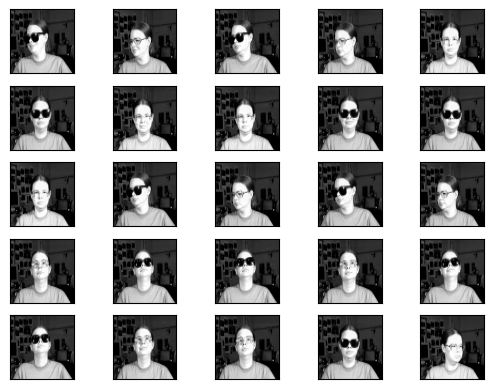

In [64]:
#Muestra de imágenes para ver el estado de las mismas luego de las transformaciones
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_normalized[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

# **Análisis de componentes principales (PCA)**

Se procede primero con el aplanamiento de las imágenes en un vector y se ingresan a una matriz la cual se centra con la media. Segundo, la descomposición espectral, en la que se sacan los eigenvalores y eigenvectores. Tercero, se calculan las varianzas total, individuales y acumulada con los eigenvalores sacados, y ello servirá para el posterior PCA (Principal Component Analysis).

In [65]:
#Aplanamiento de imágenes
img_vectorizadas = [i.flatten() for i in images_normalized]
imagenes_matriz = np.vstack(img_vectorizadas)
imagenes_matriz = imagenes_matriz-imagenes_matriz.mean()
print(imagenes_matriz.shape)

(624, 4096)


In [66]:
#descomposición en eigenvectores, eigenvalores y cálculo de la matriz de covarianza 'S'
S = np.corrcoef(imagenes_matriz.T)
eigenvalues, eigenvectors = np.linalg.eigh(S)

In [67]:
#varianza total, individuales, acumulada
var_total = eigenvalues.sum()
var_ind = eigenvalues[::-1]/var_total
var_acum = var_ind.cumsum()

In [68]:
nombres_pc = []
for i in range(len(eigenvalues)):
    nombres_pc.append('PC' + str(i+1))

A continuación se visualiza la gráfica de barras de varianza total acumulada contra los componentes principales (PC). En este análisis, se toman los eigenvalores que representan la cantidad de varianza que está contenida en cada una de las componentes principales. Por lo tanto, en el gráfico siguiente se muestra cuánta varianza total está siendo explicada a medida que consideramos más componentes principales.

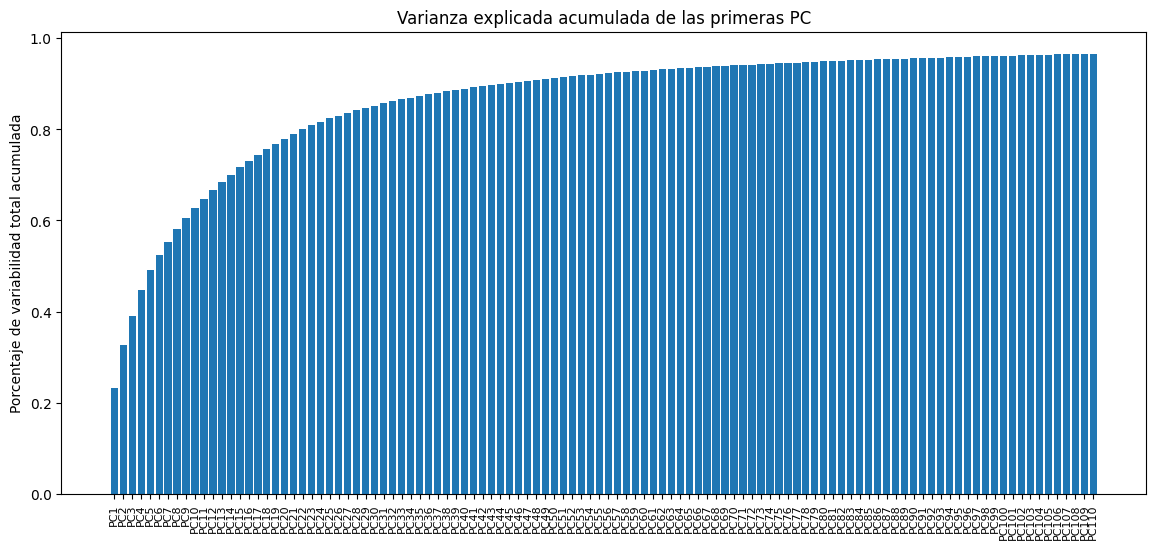

In [69]:
# Visualización de la varianza explicada acumulada en las primeras 30 componentes principales:
fig = plt.figure(figsize=(14, 6))
plt.bar(x=nombres_pc[:110], height = var_acum[:110])
plt.xticks(fontsize=8)
plt.xticks(rotation='vertical')
plt.ylabel('Porcentaje de variabilidad total acumulada')
plt.title('Varianza explicada acumulada de las primeras PC')
plt.show()

Se observa que en los últimos componentes de la gráfica anterior (valores de 100 en adelante), el porcentaje de varianza acumulada no tiene un incremento significativo. Lo que nos da un primer indicio sobre el número óptimo de dichos componentes principales.

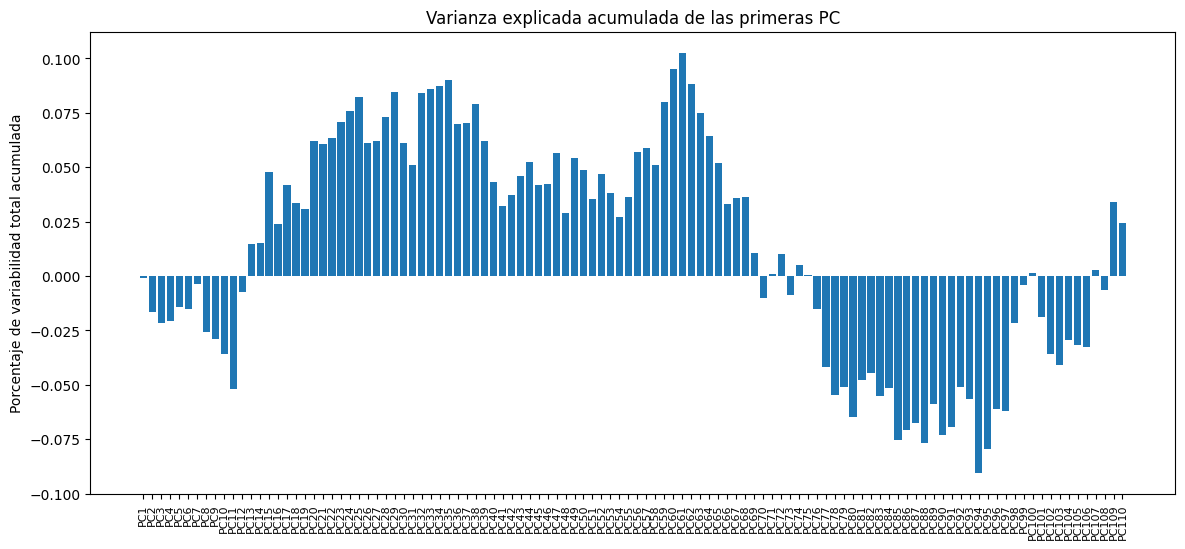

In [70]:
eigen_vectors_total = eigenvectors.sum(axis=1)
var_ind = eigen_vectors_total[::-1] / np.linalg.norm(eigen_vectors_total)
var_acum = var_ind.cumsum()

nombres_pc = []
for i in range(len(eigenvectors)):
    nombres_pc.append("PC"+str(i+1))

fig = plt.figure(figsize=(14, 6))
plt.bar(x=nombres_pc[:110], height=var_acum[:110])
plt.xticks(rotation='vertical')
plt.xticks(fontsize=8)
plt.ylabel('Porcentaje de variabilidad total acumulada')
plt.title('Varianza explicada acumulada de las primeras PC')
plt.show()


En la gráfica anterior en cambio, las componentes principales son los eigenvectores (valores propios) de la matriz de covarianza de los datos. Estos eigenvectores representan las direcciones en las cuales los datos tienen la máxima variabilidad.

En el contexto de imágenes, cada eigenvector podría considerarse como un 'patrón' específico que captura una cierta variabilidad en las imágenes como se dijo anteriormente. En el siguiente paso se hace una muestra de estos patrones detectados por el programa.

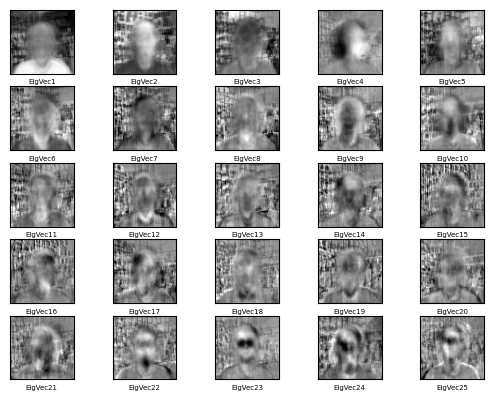

In [71]:
#Vectores propios como imagen
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(eigenvectors[:,-(i+1)].reshape(images_gray[0].shape), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('EigVec' + str(i+1), fontsize = 5)
plt.show()

# **Proyecciones en n componentes:**

Las proyecciones de las imágenes en las primeras n componentes principales representan cómo cada imagen se puede expresar o aproximar utilizando una combinación de las primeras n componentes principales. Cada proyección es un conjunto de valores que indica cuánto contribuye cada componente principal a la representación de la imagen original. Estas proyecciones son útiles porque permiten representar las imágenes en un espacio de dimensionalidad reducida, donde las dimensiones están definidas por las componentes principales.

En los apartados siguientes se hacen los cálculos de estas proyecciones con sus matrices de correlación y gráficos de distribución.

In [72]:
#Proyecciones en las primeras n_comp componentes principales:
n_comp = 10
n_obs = len(images_normalized)
proy_pc = np.empty((n_obs,n_comp), dtype = 'float')

for i in range(len(images_normalized)):
  for j in range(n_comp):
    proy_pc[i,j] = np.dot(eigenvectors[:,-j], imagenes_matriz[i,:])

proy_pc.shape

(624, 10)

In [73]:
Proy_PC = pd.DataFrame(proy_pc)
Proy_PC.columns = nombres_pc[0:n_comp]
Proy_PC.corr()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
PC1   1.000000  0.529361  0.023947 -0.065077  0.115674 -0.033200 -0.084237   
PC2   0.529361  1.000000 -0.579315  0.499344  0.131625 -0.028576 -0.564266   
PC3   0.023947 -0.579315  1.000000 -0.496493  0.121953  0.444548  0.305268   
PC4  -0.065077  0.499344 -0.496493  1.000000  0.136963 -0.333729 -0.072874   
PC5   0.115674  0.131625  0.121953  0.136963  1.000000  0.045171 -0.094190   
PC6  -0.033200 -0.028576  0.444548 -0.333729  0.045171  1.000000 -0.148991   
PC7  -0.084237 -0.564266  0.305268 -0.072874 -0.094190 -0.148991  1.000000   
PC8  -0.052678 -0.088331 -0.063163  0.058015 -0.152753 -0.027320  0.085955   
PC9   0.230882  0.346579 -0.190115  0.281795  0.211433 -0.038498 -0.022647   
PC10 -0.150327 -0.046057 -0.070930  0.090568  0.138993 -0.326474  0.044322   

           PC8       PC9      PC10  
PC1  -0.052678  0.230882 -0.150327  
PC2  -0.088331  0.346579 -0.046057  
PC3  -0.063163 -0.190115 -0.070930  
PC4   0.058015  0.281795  0.090568  
PC5  -0.152753  0.211433  0.138993  
PC6  -0.027320 -0.038498 -0.326474  
PC7   0.085955 -0.022647  0.044322  
PC8   1.000000  0.007971  0.005297  
PC9   0.007971  1.000000 -0.088252  
PC10  0.005297 -0.088252  1.000000

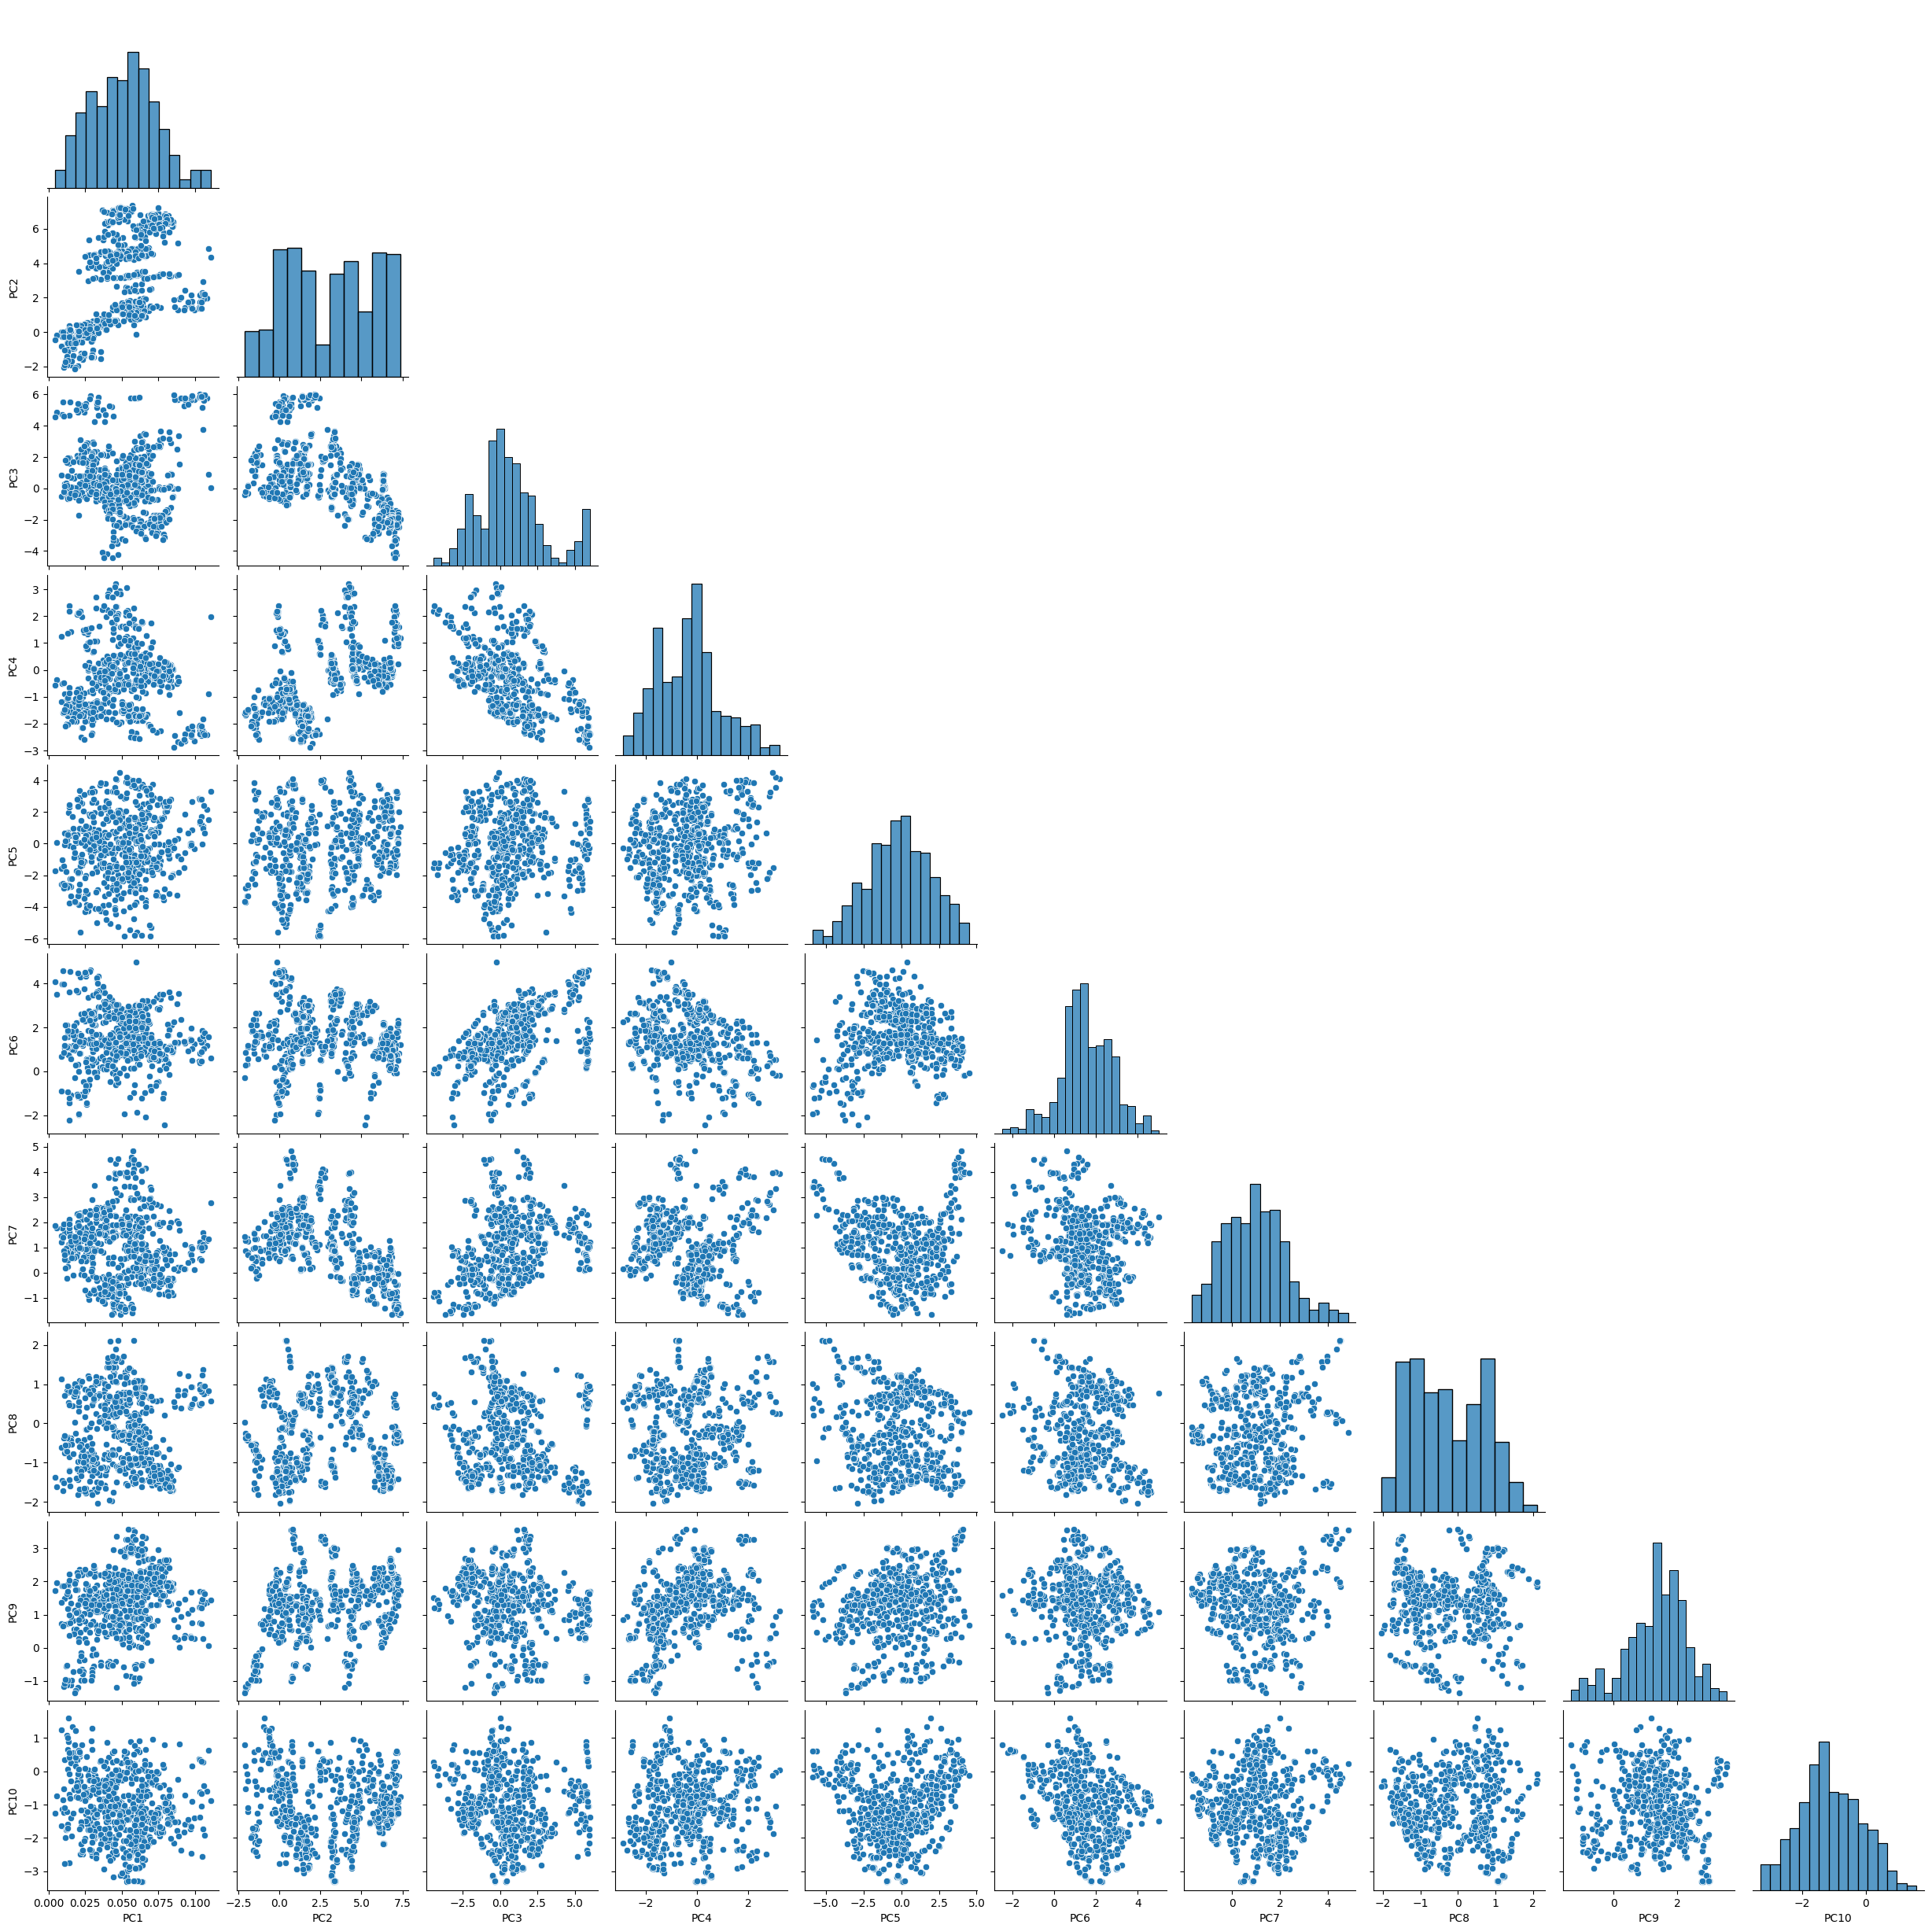

In [74]:
sns.pairplot(Proy_PC, corner = True)

# **Visualizacion de la relación entre variables**

In [75]:
#Extracción de las características de las imágenes de los nombres del archivo
patron = r"/faces/(\w+)/\w+_(\w+)_(\w+)_(\w+)_(\d+)\.pgm"

#Iterar sobre las etiquetas y extraer la información
resultados = [(re.search(patron, etiqueta).groups() if re.search(patron, etiqueta) else None) for etiqueta in etiquetas]

#Filtrar resultados no nulos
resultados = [res for res in resultados if res]

#Desempaquetar resultados en listas separadas
sujetos, perfiles, expresiones, ojos, numeros = zip(*resultados)

Esta primera visualización muestra la relación entre las variables originales (perfiles del rostro, ojos, expresion) en un espacio bidimensional. La variable 'ojos' hace referencia a la característica de si lleva gafas (sunglasses) o no (open). Cada punto en el gráfico representa una combinación específica de los valores de estas variables.

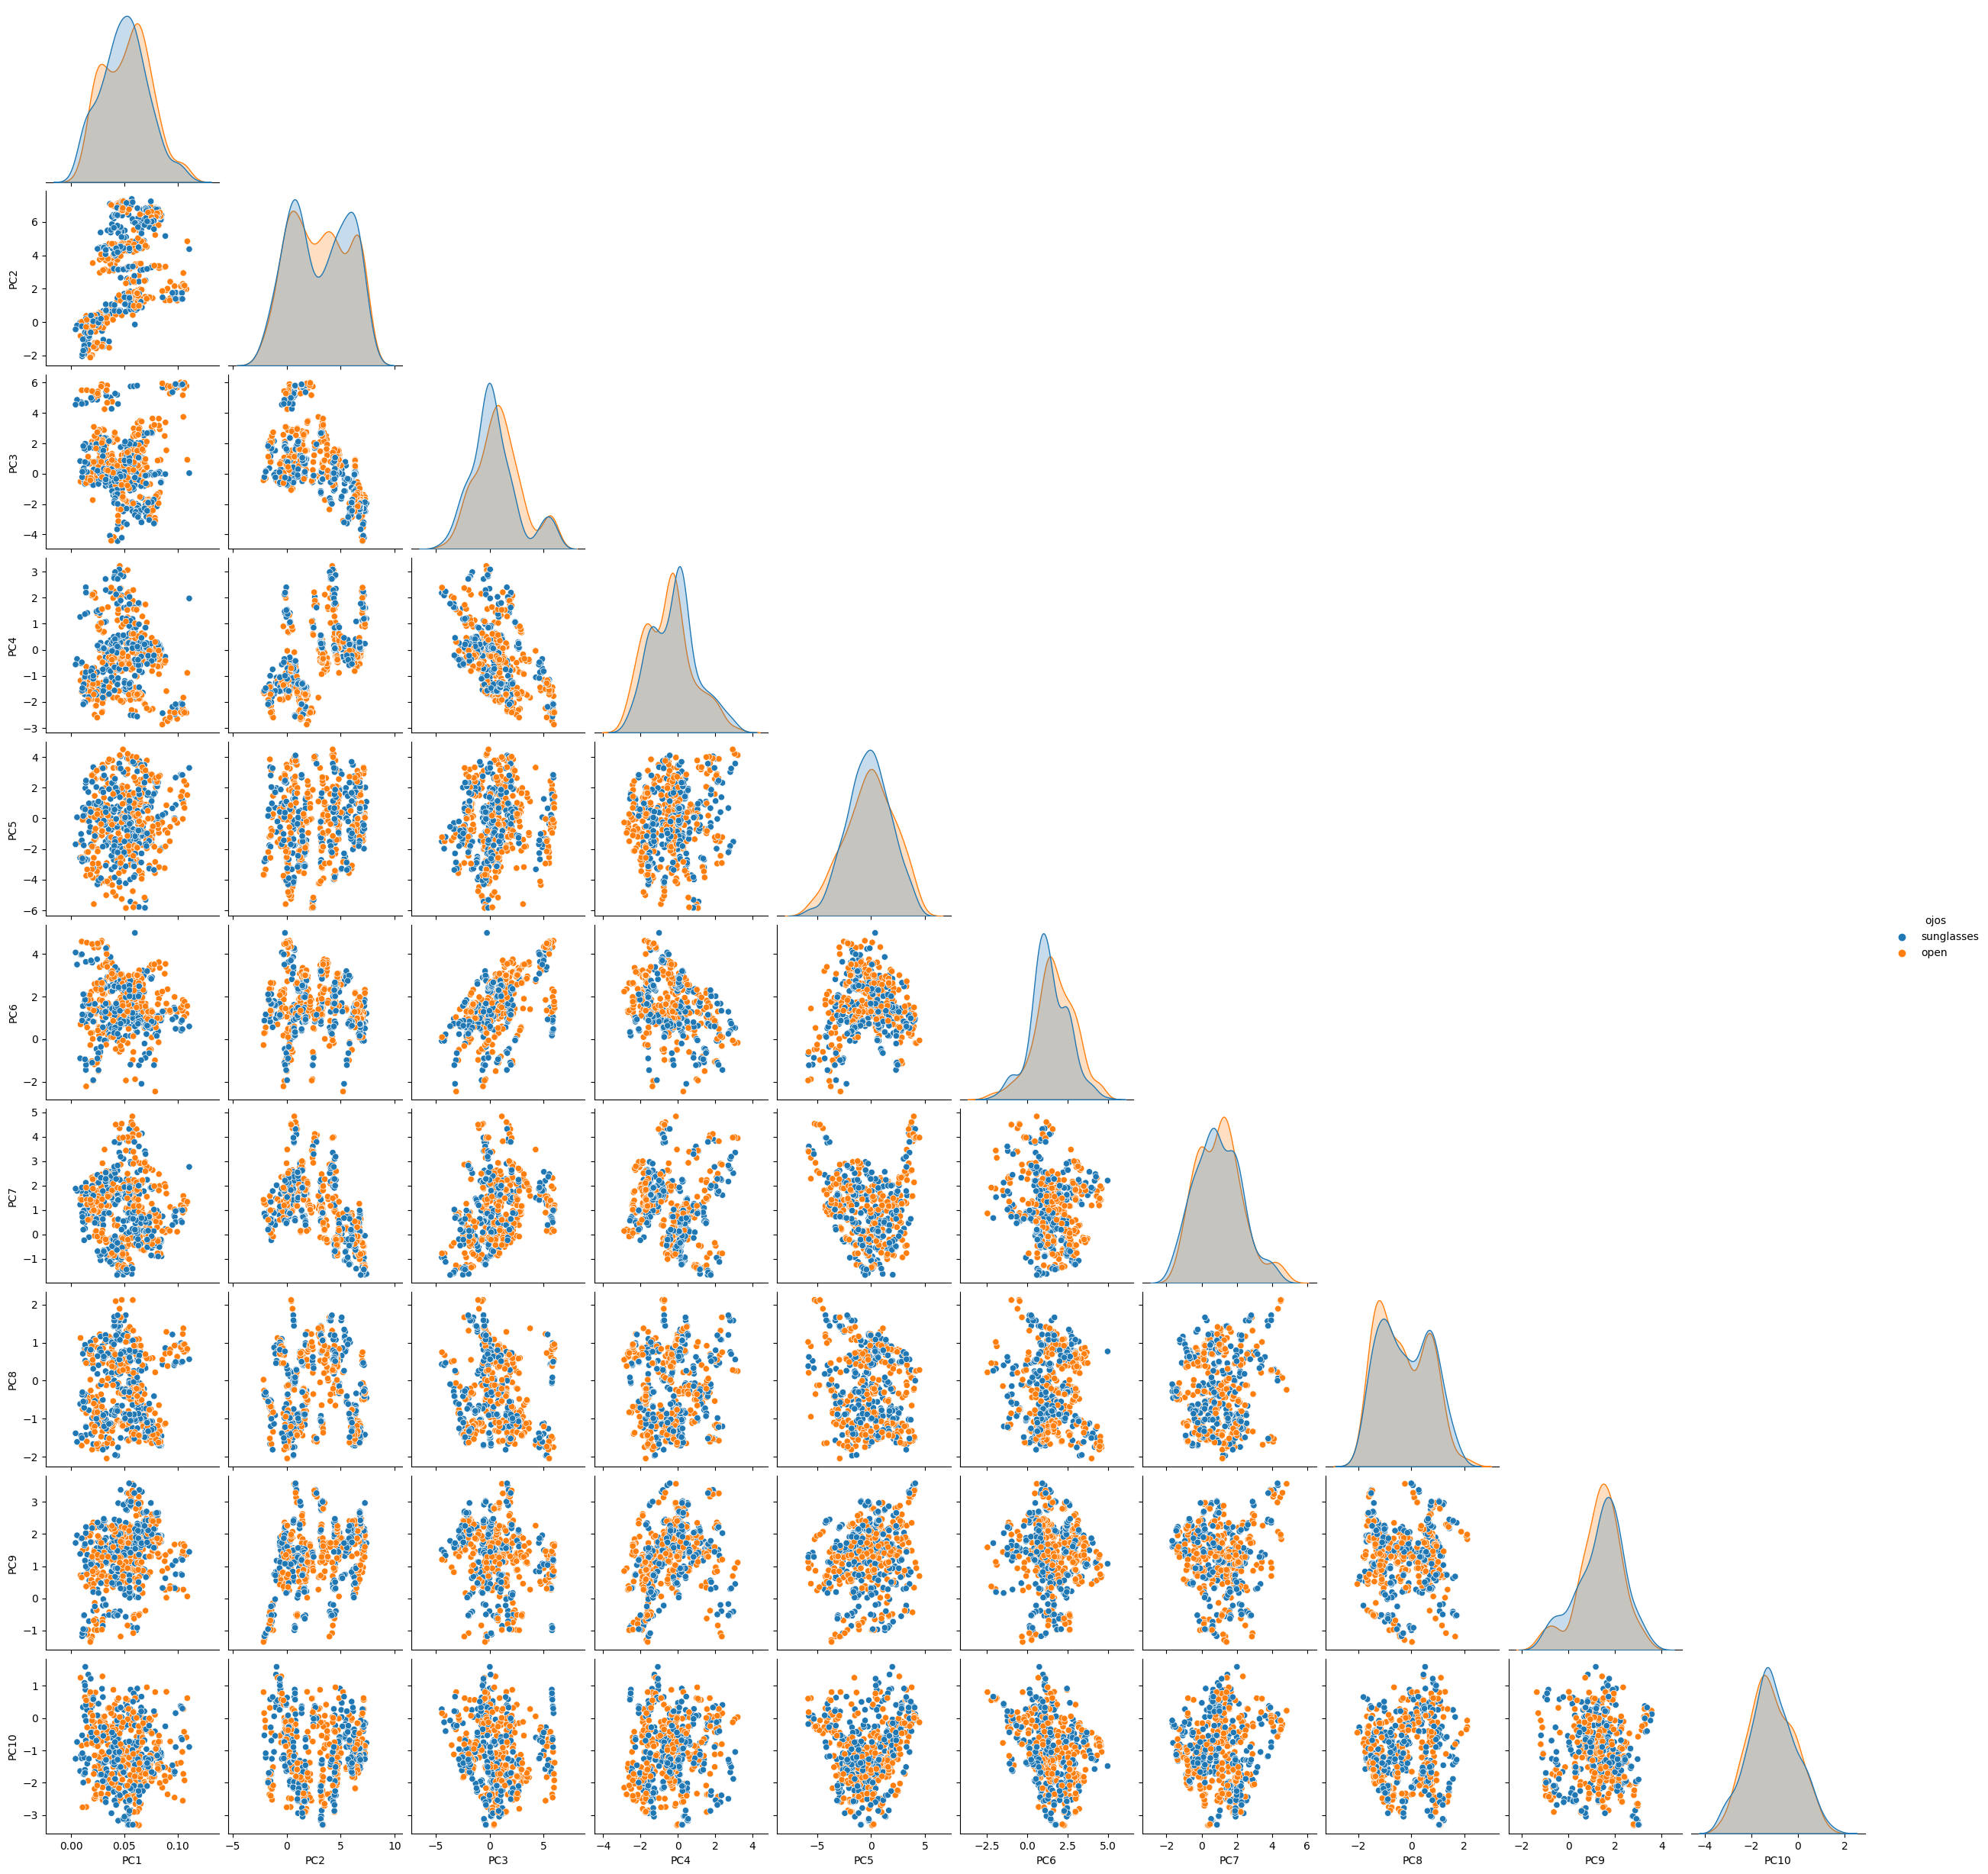

In [76]:
Proy_PC['perfiles'] = perfiles
Proy_PC['ojos'] = ojos
Proy_PC['expresion'] = expresiones

sns.pairplot(Proy_PC, corner = True, hue = 'ojos')

In [77]:
descomposicion_imagenes = PCA()
descomposicion_imagenes.fit(imagenes_matriz)

PCA()

In [78]:
Proy2 = descomposicion_imagenes.transform(imagenes_matriz)
Proy2 = pd.DataFrame(Proy2[:,0:n_comp])
Proy2.columns = nombres_pc[0:n_comp]

Proy2['perfiles'] = perfiles
Proy2['ojos'] = ojos
Proy2['expresion'] = expresiones

Esta segunda visualización mostrada a continuación utiliza PCA para reducir la dimensionalidad de los datos originales y mostrar las primeras componentes principales. Este enfoque puede ayudar a capturar la variabilidad más importante en los datos, lo que a menudo facilita la visualización.

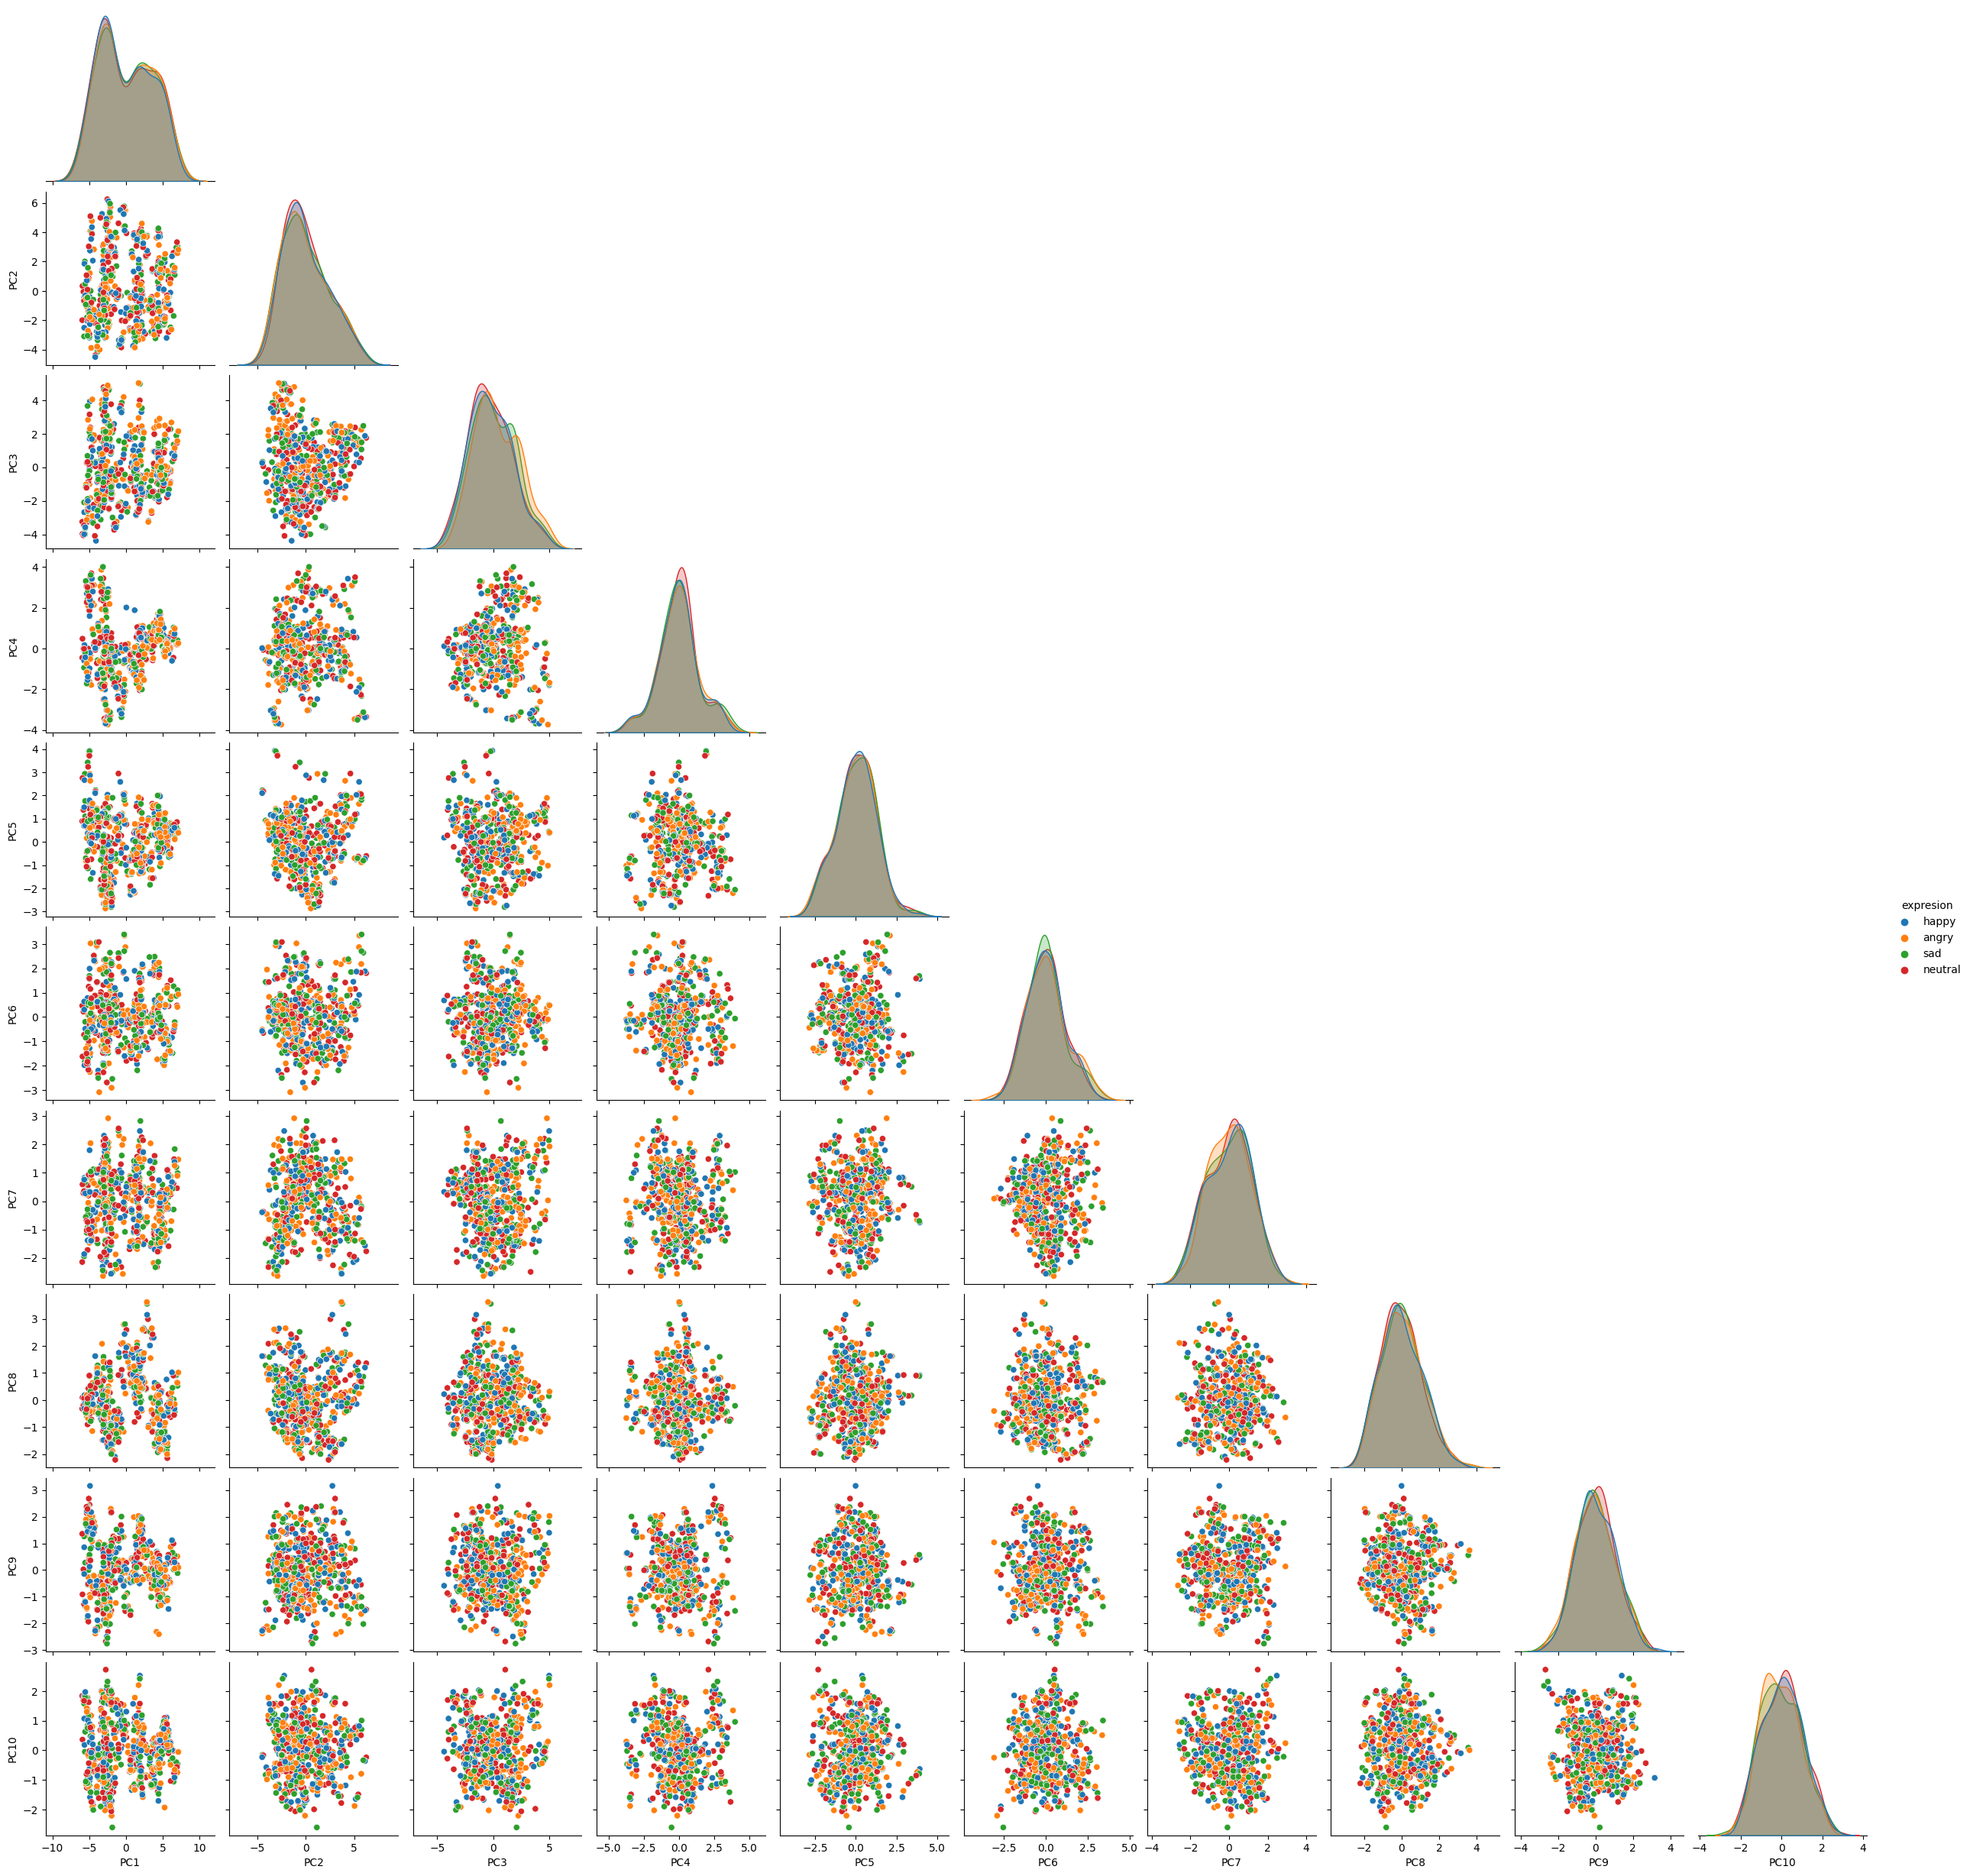

In [79]:
sns.pairplot(Proy2, hue = 'expresion', corner = True)

In [80]:
Proy2.corr(numeric_only=True)

PC1           PC2           PC3           PC4           PC5  \
PC1   1.000000e+00 -1.178983e-15 -9.467365e-17 -2.195180e-17 -2.955433e-16   
PC2  -1.178983e-15  1.000000e+00  2.218216e-16  1.951292e-16  2.662871e-16   
PC3  -9.467365e-17  2.218216e-16  1.000000e+00 -8.341083e-18 -1.929666e-16   
PC4  -2.195180e-17  1.951292e-16 -8.341083e-18  1.000000e+00 -4.970452e-16   
PC5  -2.955433e-16  2.662871e-16 -1.929666e-16 -4.970452e-16  1.000000e+00   
PC6   1.126351e-15  3.044007e-17  2.635867e-17  6.670208e-17 -2.139159e-16   
PC7  -1.295389e-16  1.062360e-15 -4.988936e-16 -3.802497e-16 -4.065150e-16   
PC8  -3.688138e-16 -3.469210e-16 -8.150193e-17  2.093933e-16  3.632272e-16   
PC9   6.219257e-16 -2.888329e-16 -1.308015e-16 -1.561727e-16 -1.646975e-16   
PC10 -4.266336e-17  2.737665e-16  2.116578e-16  3.842900e-17  2.532243e-16   

               PC6           PC7           PC8           PC9          PC10  
PC1   1.126351e-15 -1.295389e-16 -3.688138e-16  6.219257e-16 -4.266336e-17  
PC2   3.044007e-17  1.062360e-15 -3.469210e-16 -2.888329e-16  2.737665e-16  
PC3   2.635867e-17 -4.988936e-16 -8.150193e-17 -1.308015e-16  2.116578e-16  
PC4   6.670208e-17 -3.802497e-16  2.093933e-16 -1.561727e-16  3.842900e-17  
PC5  -2.139159e-16 -4.065150e-16  3.632272e-16 -1.646975e-16  2.532243e-16  
PC6   1.000000e+00  4.579993e-16 -1.790945e-16 -1.861019e-18  2.122588e-16  
PC7   4.579993e-16  1.000000e+00 -2.195975e-16  2.767799e-18 -2.574849e-16  
PC8  -1.790945e-16 -2.195975e-16  1.000000e+00  1.194431e-16 -2.758265e-16  
PC9  -1.861019e-18  2.767799e-18  1.194431e-16  1.000000e+00  5.771746e-16  
PC10  2.122588e-16 -2.574849e-16 -2.758265e-16  5.771746e-16  1.000000e+00

## **Análisis de imágenes por clase**

In [81]:
#Valores únicos en la variable objetivo
print(set(labels))

{'sunglasses', 'open'}


In [82]:
print({label: labels.count(label) for label in set(labels)})

{'sunglasses': 311, 'open': 313}


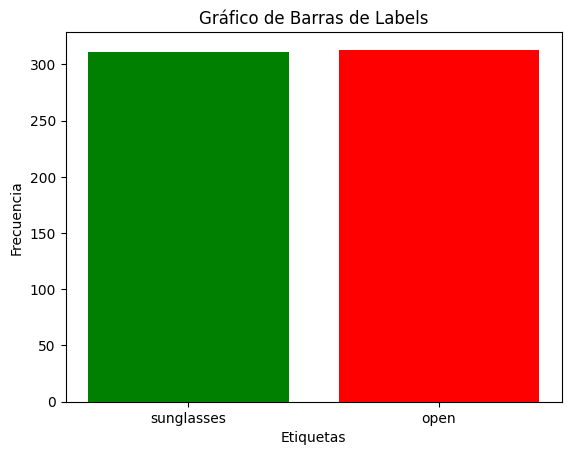

In [83]:
contador = Counter(labels)
etiquetas_unicas = list(contador.keys())
frecuencias = list(contador.values())

plt.bar(etiquetas_unicas, frecuencias, color=['green','red'])
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Labels')
plt.show()

Basándonos en los resultados previos, se concluye que de las 624 imágenes de caras, 313 no presentan gafas ('open'), mientras que 311 sí las tienen ('sunglasses').

Dado el número adecuado de datos para ambos valores únicos de la variable objetivo en el conjunto completo, no se considera necesario realizar un balanceo entre ellos.

# **Declaración de etiquetas y análisis de datos**

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

**Clasificación de imágenes**:

0 : open (sin gafas, ojos abiertos)

1 : sunglasses (con gafas)


<center>

En secciones anteriores, el análisis de PCA proporcionó información valiosa para vislumbrar el número óptimo de componentes principales. Este código que se presenta ahora, utiliza la varianza explicada acumulada para determinar cuántos PC son necesarios para retener una cierta cantidad de información esencial con un porcentaje de varianza objetivo estipulado del 95%, y se usa para tomar una decisión informada y automatizada sobre cuántos componentes principales utilizar en el siguiente paso del análisis, el cual es la transformación del conjunto de datos con dicho parámetro.

In [84]:
pca = PCA()
pca.fit(imagenes_matriz)
porcentaje_varianza_objetivo = 0.95
n_componentes_optimo = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= porcentaje_varianza_objetivo) + 1

#aplicar PCA con el número optimo de componentes
pca_optimo = PCA(n_components=n_componentes_optimo)
X_transformado = pca_optimo.fit_transform(img_vectorizadas)

print(f'Número óptimo de componentes: {n_componentes_optimo}')

Número óptimo de componentes: 97


A continuación se hace una estandarización del conjunto de datos anterior y se realiza la división de los mismos en entrenamiento (70%) , prueba (15%) y validación (15%)

In [85]:
scaler = StandardScaler()
imagenes_estandarizadas = scaler.fit_transform(X_transformado)

In [86]:
#Partición de los datos en train 70%, test 15%, y validation 15%
X_train, X_temp, y_train, y_temp = train_test_split(imagenes_estandarizadas, labels, test_size=0.3, random_state=42)

#Dividir el conjunto temporal para obtener conjuntos de validación y prueba
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **Elección del modelo**

In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# se define el modelo SVC con kernel lineal
model = SVC(kernel='linear', probability=True, random_state=42)

# se define el espacio de búsqueda de hiperparámetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(model, param_grid, refit=True, verbose=3, scoring='accuracy')
grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...........................C=0.001;, score=0.534 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.563 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.563 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.529 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.830 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.839 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.828 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.839 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.839 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.852 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

# **Revisión de Métricas**

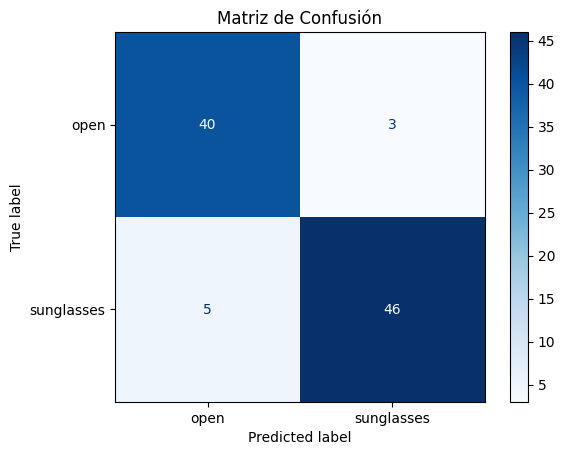

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

y_pred = best_model.predict(X_test)

# Se calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['open', 'sunglasses'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['open', 'sunglasses'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [89]:
# Se calculan otras métricas de clasificación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='sunglasses'))
print("Recall:", recall_score(y_test, y_pred, pos_label='sunglasses'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='sunglasses'))

Accuracy: 0.9148936170212766
Precision: 0.9387755102040817
Recall: 0.9019607843137255
F1 Score: 0.92


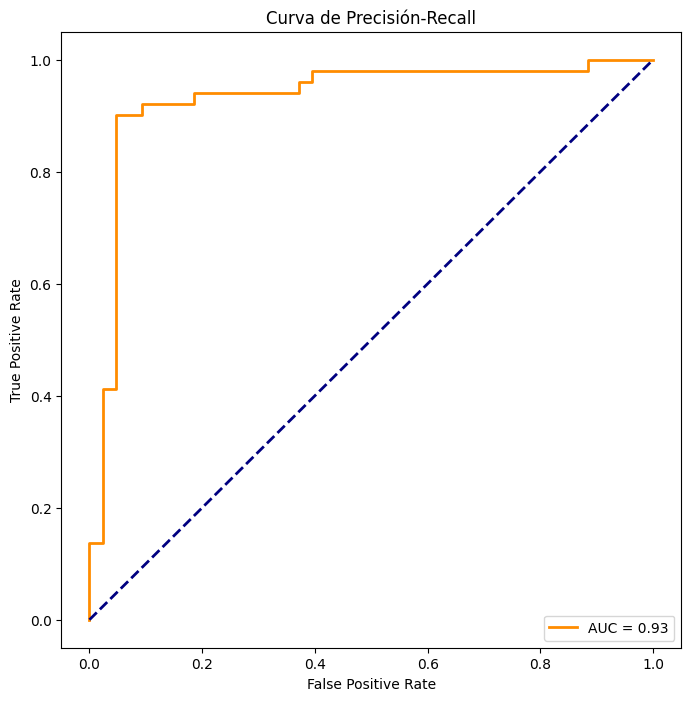

In [90]:
# Se calcula la curva ROC y el AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='sunglasses')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva de Precisión-Recall')
plt.legend(loc='lower right')
plt.show()

In [ ]:
yt_pred = best_model.predict(X_train)

# Se calcula la matriz de confusión
cm = confusion_matrix(y_train, yt_pred, labels=['open', 'sunglasses'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['open', 'sunglasses'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Se calculan otras métricas de clasificación
print("Accuracy:", accuracy_score(y_train, yt_pred))
print("Precision:", precision_score(y_train, yt_pred, pos_label='sunglasses'))
print("Recall:", recall_score(y_train, yt_pred, pos_label='sunglasses'))
print("F1 Score:", f1_score(y_train, yt_pred, pos_label='sunglasses'))

In [ ]:
# Se calcula la curva ROC y el AUC
yt_prob = best_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, yt_prob, pos_label='sunglasses')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva de Precisión-Recall')
plt.legend(loc='lower right')
plt.show()

In [47]:
############## ESTO ES PARA LEER Y GUARDAR ARCHIVOS EN DRIVE

# ruta_raiz = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces'
# rutas_imagenes = []
# for directorio_raiz, directorios, archivos in os.walk(ruta_raiz):
#     for archivo in archivos:
#         if archivo.lower().endswith('_2.pgm'):
#             ruta_completa = os.path.join(directorio_raiz, archivo)
#             rutas_imagenes.append(ruta_completa)

# imag = [cv2.resize(cv2.imread(ruta), (64, 64)) for ruta in rutas_imagenes]
# etiquetas = [ruta for ruta in rutas_imagenes]

# ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'
# with open(ruta_archivo, 'wb') as archivo:
#     pickle.dump(imag, archivo)

# ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'
# with open(ruta_archivo, 'wb') as archivo:
#     pickle.dump(etiquetas, archivo)